# Библиотеки и инициализация процессов

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.3}'.format

import praw
import snscrape.modules.twitter as sntwitter
import datetime
import requests
from tqdm.notebook import tqdm
import cryptocompare
import getpass
import math
import numpy as np
import seaborn as sns
import scipy.stats as ss
import random
from collections import defaultdict

import nltk
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

import re
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()


stop_words=set(stopwords.words("english"))

api_key = getpass.getpass('Api Key for CryptoCompare parsing:')
client_id = getpass.getpass('Cliend id for Reddit parsing:')
client_secret = getpass.getpass('Cliend secret for Reddit parsing:')



from IPython.core.display import display, HTML
display(HTML('<style>.container {width: 100% !important; } </style>'))

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Api Key for CryptoCompare parsing:········
Cliend id for Reddit parsing:········
Cliend secret for Reddit parsing:········


# Парсинг

## Reddit

author - автор поста - сообщество или персона

title - заголовок

score - количество лайков поста

id - id поста

subreddit - один из тэгов для парсинга (['Bitcoin','Crypto','Cryptocurrency','Cryptocurrencies','Blockchain','Binance'])

num_comments - общее число комментариев

body - содержание поста (только текст)

created - время создания

top 1-10 comment - содержание комментария

top 1-10 comment score - количество лайков комментария

top 1-10 comment author - автор комментария

top 1-10 comment time - время комментария

total comments score - сумма лайков комментариев под постом

subreddit subscribers - количетсво подписчиков (если пост оставлен пабликом)

In [ ]:
reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent='ParsBars')

posts_total = []
subreddit_list = ['Bitcoin','Crypto','Cryptocurrency','Cryptocurrencies','Blockchain','Binance']

for x in subreddit_list:
    posts = []
    ml_subreddit = reddit.subreddit(x).hot(limit=1000000)
    sub_c = reddit.subreddit(x)
    sub_c = sub_c.subscribers
    
    for post in tqdm(ml_subreddit):
        posts_loc = []
        posts_loc.append([post.author,post.title, post.score, post.id, post.subreddit, post.num_comments, post.selftext, datetime.datetime.fromtimestamp(post.created)])
        submission = reddit.submission(id=post.id)
        comm = []
        scor = []
        aut = []
        tim = []
        submission.comments.replace_more(limit=0)
        for top_level_comment in submission.comments:
            comm += [top_level_comment.body]
            scor += [top_level_comment.score]
            aut += [top_level_comment.author]
            tim += [datetime.datetime.fromtimestamp(top_level_comment.created)]
        df = pd.DataFrame([comm,scor,aut,tim],index=['comment','comment_score','aut','tim']).T.sort_values(by='comment_score',ascending=False).iloc[:10]
        shap = min(df.shape[0],10)
        comm_df = pd.DataFrame(df.iloc[:,0].tolist()+df.iloc[:,1].tolist()+df.iloc[:,2].tolist() + df.iloc[:,3].tolist() \
                               + [sum(scor),sub_c],index= ['top {} comment'.format(x) for x in range(1,shap+1)]\
                               + ['top {} comment score'.format(x) for x in range(1,shap+1)] \
                               + ['top {} comment author'.format(x) for x in range(1,shap+1)] \
                               + ['top {} comment time'.format(x) for x in range(1,shap+1)] \
                               + ['total comments score','subreddit subscribers']).T
        posts +=[pd.concat([pd.DataFrame(posts_loc,columns=['author','title', 'score', 'id', 'subreddit', 'num_comments', 'body', 'created']),comm_df],axis=1)]
    
    posts = pd.concat(posts)
    posts_total += [posts]
posts_total = pd.concat(posts_total).to_csv('reddit.csv')

## Twitter

date - время создания

id - id поста

content - содержание поста (только текстовая составляющая)

username - имя автора поста

subreddit - один из тэгов для парсинга (['Bitcoin','Crypto','Cryptocurrency','Cryptocurrencies','Blockchain','Binance'])

In [ ]:
maxTweets = 1000000

total_tweet = []
subreddit_list = ['Bitcoin','Crypto','Cryptocurrency','Cryptocurrencies','Blockchain','Binance']
for x in subreddit_list:
    posts_total = []
    try:
        for i,tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper(x).get_items())):
            if i>maxTweets:
                break
            posts_total.append({'date':tweet.date, 
                                 'id':tweet.id, 
                                 'content':tweet.content, 
                                 'username':tweet.username})
    except:
        pass
    
    posts_total = pd.DataFrame(posts_total)
    posts_total['subreddit'] = x
    total_tweet += [posts_total]
posts_total = pd.concat(total_tweet).to_csv('twitter.csv')

## Bitcoin price 

Минимальное время спарсенных твиттов/реддитов - '2017-12-14 15:38:42'

Максимальное время спарсенных твиттов/реддитов - '2021-09-24 07:03:18'

In [ ]:
start_point = int(datetime.datetime.timestamp(datetime.datetime.strptime('2017-12-14 15:38:42', "%Y-%m-%d %H:%M:%S")))
end_point = int(datetime.datetime.timestamp(datetime.datetime.strptime('2021-09-24 07:03:18', "%Y-%m-%d %H:%M:%S")))
days_between = (datetime.datetime.strptime('2021-09-24 07:03:18', "%Y-%m-%d %H:%M:%S")-datetime.datetime.strptime('2017-12-14 15:38:42', "%Y-%m-%d %H:%M:%S")).days+1
hours_between = days_between*24
minutes_between = hours_between*60

### Daily

time - время среза данных

high - максимальная цена

low - минимальная цена

open - цена открытия

volumefrom - минимальный объем сделки за период

volumeto - максимальный объем сделки за период

close - цена закрытия 

conversionType - техническое поле

conversionSymbol - техническое поле

top_tier_volume_quote - максимальный sell-side объем по BTC

top_tier_volume_base - максимальный buy-side объем по BTC

top_tier_volume_total - максимальный суммарный объем по BTC

cccagg_volume_quote - средневзешенный sell-side объем по BTC

cccagg_volume_base - средневзешенный buy-side объем по BTC

cccagg_volume_total - средневзешенный суммарный объем по BTC

total_volume_quote - суммарный sell-side объем по BTC

total_volume_base - суммарный buy-price объем по BTC

total_volume_total - суммарный объем по BTC

volume - суммарный объем биржи по всем валютам

In [ ]:
assets = 'BTC'

# В целом по биржам
url_daily_exchange_vol = 'https://min-api.cryptocompare.com/data/exchange/histoday?tsym=USD&limit={}'.format(days_between) + api_key
data_exchange = pd.DataFrame(requests.get(url_daily_exchange_vol).json()['Data']).iloc[:,1:]


url_daily_pair = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&limit={}'.format(assets,days_between) + api_key
# По активу
url_daily_symbol_vol = 'https://min-api.cryptocompare.com/data/symbol/histoday?fsym={}&tsym=USD&limit={}'.format(assets,days_between) + api_key

try:
    data_main = pd.DataFrame(requests.get(url_daily_pair).json()['Data']['Data'])
    data_vol = pd.DataFrame(requests.get(url_daily_symbol_vol).json()['Data']).iloc[:,1:]
    data = pd.concat([data_main,data_vol,data_exchange],axis=1)
except KeyError:
    print("I can't find "+assets + ' in USD')
data.to_csv('BTC day.csv')

In [5]:
data = pd.read_csv('BTC day.csv',index_col=0)
print(data.shape)
data.head()

(1381, 19)


,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,top_tier_volume_quote,top_tier_volume_base,top_tier_volume_total,cccagg_volume_quote,cccagg_volume_base,cccagg_volume_total,total_volume_quote,total_volume_base,total_volume_total,volume
0,1513209600,1.69e+04,1.6e+04,1.63e+04,1.08e+05,1.77e+09,1.65e+04,direct,NaN,6.34e+09,3.23e+09,9.57e+09,6.74e+09,3.46e+09,1.02e+10,1.37e+10,8.71e+09,2.24e+10,1.63e+10
1,1513296000,1.8e+04,1.64e+04,1.65e+04,1.54e+05,2.68e+09,1.76e+04,direct,NaN,5.4e+09,4.47e+09,9.87e+09,6.36e+09,5.09e+09,1.14e+10,1.24e+10,1.25e+10,2.5e+10,1.63e+10
2,1513382400,1.96e+04,1.73e+04,1.76e+04,1.12e+05,2.08e+09,1.93e+04,direct,NaN,5.08e+09,3.84e+09,8.92e+09,5.96e+09,4.37e+09,1.03e+10,1.16e+10,1.16e+10,2.33e+10,1.39e+10
3,1513468800,1.99e+04,1.88e+04,1.93e+04,1.17e+05,2.26e+09,1.91e+04,direct,NaN,5.67e+09,4.08e+09,9.74e+09,6.6e+09,4.68e+09,1.13e+10,1.3e+10,1.21e+10,2.5e+10,1.53e+10
4,1513555200,1.92e+04,1.81e+04,1.91e+04,1.39e+05,2.6e+09,1.9e+04,direct,NaN,6.22e+09,4.1e+09,1.03e+10,7.22e+09,4.82e+09,1.2e+10,1.41e+10,1.17e+10,2.58e+10,1.78e+10


### Hourly

time - время среза данных

high - максимальная цена

low - минимальная цена

open - цена открытия

volumefrom - минимальный объем сделки за период

volumeto - максимальный объем сделки за период

close - цена закрытия 

conversionType - техническое поле

conversionSymbol - техническое поле

top_tier_volume_quote - максимальный sell-side объем по BTC

top_tier_volume_base - максимальный buy-side объем по BTC

top_tier_volume_total - максимальный суммарный объем по BTC

cccagg_volume_quote - средневзешенный sell-side объем по BTC

cccagg_volume_base - средневзешенный buy-side объем по BTC

cccagg_volume_total - средневзешенный суммарный объем по BTC

total_volume_quote - суммарный sell-side объем по BTC

total_volume_base - суммарный buy-side объем по BTC

total_volume_total - суммарный объем по BTC

volume - суммарный объем биржи по всем валютам

In [ ]:
points_of_time = [int(datetime.datetime.timestamp((datetime.datetime.fromtimestamp(end_point)-datetime.timedelta(hours=x*2000))))  for x in range(math.ceil(hours_between/2000)+1)]
data_part = []
for p in points_of_time:
    # В целом по биржам
    url_hourly_exchange_vol = 'https://min-api.cryptocompare.com/data/exchange/histohour?tsym=USD&limit=2000&toTs={}'.format(p) + api_key
    data_exchange = pd.DataFrame(requests.get(url_hourly_exchange_vol).json()['Data']).iloc[:,1:]
    
    
    url_hourly_pair = 'https://min-api.cryptocompare.com/data/v2/histohour?fsym={}&tsym=USD&limit=2000&toTs={}'.format(assets,p) + api_key
    # По активу
    url_hourly_symbol_vol = 'https://min-api.cryptocompare.com/data/symbol/histohour?fsym={}&tsym=USD&limit=2000&toTs={}'.format(assets,p) + api_key
    
    try:
        data_main = pd.DataFrame(requests.get(url_hourly_pair).json()['Data']['Data'])
        data_vol = pd.DataFrame(requests.get(url_hourly_symbol_vol).json()['Data']).iloc[:,1:]
        data = pd.concat([data_main,data_vol,data_exchange],axis=1)
        data_part += [data]
    except KeyError:
        print("I can't find "+assets + ' in USD')
pd.concat(data_part).sort_values(by='time').reset_index(drop=True).to_csv('BTC hour.csv')

In [6]:
data = pd.read_csv('BTC hour.csv',index_col=0)
print(data.shape)
data.head()

(36018, 19)


,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,top_tier_volume_quote,top_tier_volume_base,top_tier_volume_total,cccagg_volume_quote,cccagg_volume_base,cccagg_volume_total,total_volume_quote,total_volume_base,total_volume_total,volume
0,1502856000,4.08e+03,4.03e+03,4.08e+03,3.27e+03,1.32e+07,4.05e+03,direct,NaN,2.52e+07,3.06e+07,5.59e+07,2.88e+07,3.68e+07,6.56e+07,5.74e+07,9.1e+07,1.48e+08,9.9e+07
1,1502859600,4.05e+03,3.97e+03,4.05e+03,5.91e+03,2.36e+07,3.99e+03,direct,NaN,3.09e+07,6.44e+07,9.53e+07,3.43e+07,7.38e+07,1.08e+08,6.85e+07,1.81e+08,2.5e+08,1.56e+08
2,1502863200,4.07e+03,3.94e+03,3.99e+03,5.99e+03,2.39e+07,4.06e+03,direct,NaN,3.27e+07,7.38e+07,1.06e+08,3.64e+07,8.44e+07,1.21e+08,7.27e+07,1.97e+08,2.69e+08,1.66e+08
3,1502866800,4.12e+03,4.06e+03,4.06e+03,5.14e+03,2.1e+07,4.07e+03,direct,NaN,3.02e+07,6.04e+07,9.06e+07,3.45e+07,7.77e+07,1.12e+08,6.8e+07,1.84e+08,2.52e+08,1.59e+08
4,1502870400,4.17e+03,4.06e+03,4.07e+03,4.84e+03,1.99e+07,4.16e+03,direct,NaN,2.75e+07,5.01e+07,7.76e+07,3.14e+07,6.39e+07,9.53e+07,6.25e+07,1.53e+08,2.16e+08,1.39e+08


### Minutely

Unix - время в формате Timestamp 

Date - обычный datetime формат

Symbol - BTC/USD - техническое поле

Open - Цена открытия

High - Максимальная цена

Low - Минимальная цена

Close - Цена закрытия

Volume BTC - volume_quote - sell-side объем по BTC

Volume USD - volume_base - суммарный buy-side объем по BTC

In [ ]:
pd.concat([pd.read_csv('https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_{}_minute.csv'.format(x),skiprows=1) for x in [2017,2018,2019,2020,2021]]).reset_index(drop=True).to_csv('BTC minute.csv')

In [7]:
data = pd.read_csv('BTC minute.csv',index_col=0)
print(data.shape)
data.head()

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2449405, 9)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1514764740,2017-12-31 23:59:00,BTC/USD,1.39e+04,1.39e+04,1.39e+04,1.39e+04,0.592,8.21e+03
1,1514764680,2017-12-31 23:58:00,BTC/USD,1.39e+04,1.4e+04,1.39e+04,1.4e+04,1.4,1.95e+04
2,1514764620,2017-12-31 23:57:00,BTC/USD,1.39e+04,1.39e+04,1.39e+04,1.39e+04,0.775,1.08e+04
3,1514764560,2017-12-31 23:56:00,BTC/USD,1.38e+04,1.39e+04,1.38e+04,1.39e+04,0.666,9.24e+03
4,1514764500,2017-12-31 23:55:00,BTC/USD,1.38e+04,1.38e+04,1.38e+04,1.38e+04,0.0655,9.06e+02


# EDA

## Reddit

In [75]:
reddit = pd.read_csv('Reddit.csv',index_col=0)
reddit = reddit.rename(columns={'created': 'time'})
reddit['time'] = reddit['time'].astype('object')
print(reddit.shape)
reddit.head()

(3566, 50)


,author,title,score,id,subreddit,num_comments,body,time,top 1 comment,top 2 comment,...,top 3 comment time,top 4 comment time,top 5 comment time,top 6 comment time,top 7 comment time,top 8 comment time,top 9 comment time,top 10 comment time,total comments score,subreddit subscribers
0,Bitcoin_Magazine,Bitcoin Core 22.0 Released: What’s New,184,pnlhqv,Bitcoin,49,NaN,2021-09-13 21:36:21,tldr; Bitcoin Core 22.0 is the 22nd major rele...,> The Invisible Internet Project (I2P) is anot...,...,2021-09-21 19:47:56,2021-09-14 02:51:13,2021-09-14 00:00:35,2021-09-14 09:19:25,2021-09-14 08:36:50,2021-09-13 22:35:15,2021-09-21 11:19:16,2021-09-14 10:35:25,58,3372694
0,rBitcoinMod,"Daily Discussion, September 21, 2021",89,psbyo9,Bitcoin,738,Please utilize this sticky thread for all gene...,2021-09-21 08:04:28,Public Service Announcement:\n\nhttps://bitinf...,China will bail out Everscam and US will annou...,...,2021-09-21 21:21:03,2021-09-22 03:13:37,2021-09-21 18:03:43,2021-09-21 08:22:00,2021-09-22 01:49:41,2021-09-21 18:18:00,2021-09-21 21:43:19,2021-09-21 22:34:39,822,3372694
0,alOOshXL,Me watching Bitcoin chart all day.,477,pssp4r,Bitcoin,29,NaN,2021-09-22 00:34:13,This is quite accurate...,"Same, but with less (muscle) gains.",...,2021-09-22 01:17:48,2021-09-22 03:49:17,2021-09-22 01:33:04,2021-09-22 01:56:04,2021-09-22 02:59:58,2021-09-22 03:48:28,2021-09-22 05:07:45,2021-09-22 05:04:47,72,3372694
0,Xaqaree,You Bitcoin fuckers do not understand money. I...,634,pso5rg,Bitcoin,414,I've been listening to Bitcoin podcasts and re...,2021-09-21 20:57:44,Way to put all of us in the same basket. I kno...,What if you don't like ham sandwiches,...,2021-09-21 21:15:59,2021-09-21 21:05:55,2021-09-21 23:33:35,2021-09-22 00:45:15,2021-09-21 21:06:58,2021-09-22 01:38:50,2021-09-22 01:56:42,2021-09-21 23:27:19,1926,3372694
0,Zarathustra167,Absolute nightmare cryptocurrency bill in comm...,138,pswvjz,Bitcoin,75,Bill H.R.4741 which is currently in committee ...,2021-09-22 04:23:25,Wow it’s almost like they’re trying to make de...,What if I told you that they're not your repre...,...,2021-09-22 04:29:04,2021-09-22 04:30:18,2021-09-22 05:12:54,2021-09-22 05:11:41,2021-09-22 05:00:41,2021-09-22 06:11:32,2021-09-22 06:36:41,2021-09-22 06:31:28,93,3372694


In [76]:
new_reddit = []
for x in range(reddit.shape[0]):
    main_data = pd.DataFrame(reddit.iloc[x][['author','score','id','subreddit',
           'num_comments','body','time','total comments score', 'subreddit subscribers']]).T
    main_data['part'] = 'post'
    
    sub_data = pd.DataFrame([reddit.iloc[x,8:][y:-2][::10].reset_index(drop=True) for y in range(10)]).dropna(how='all').reset_index(drop=True)
    sub_data.columns = ['body','total comments score','author','created']
    sub_data['part'] = 'comment'
    
    new_reddit += [pd.concat([main_data,sub_data],axis=0).fillna(method='ffill')]
    
reddit = pd.concat(new_reddit).sort_values(by = 'time').reset_index(drop=True)
print(reddit.shape)
reddit.head()

(18405, 11)


,author,score,id,subreddit,num_comments,body,time,total comments score,subreddit subscribers,part,created
0,davidw_-,606,7jrba2,crypto,200,NaN,2017-12-14 15:38:42,3.16e+02,208884,post,NaN
1,andrewwalton,606,7jrba2,crypto,200,"""Crypto"" means secret. It's often short for ""c...",2017-12-14 15:38:42,5.0,208884,comment,2017-12-15 00:52:54
2,rubdos,606,7jrba2,crypto,200,"Sooooo, you planning to sell t-shirts that say...",2017-12-14 15:38:42,6.0,208884,comment,2018-01-20 11:09:09
3,mockfry,606,7jrba2,crypto,200,Thank you for voicing our collective frustration,2017-12-14 15:38:42,13.0,208884,comment,2017-12-14 16:55:37
4,airpod_sleeping_pod,606,7jrba2,crypto,200,"It is true, just crypto (word) became like a b...",2017-12-14 15:38:42,14.0,208884,comment,2017-12-14 17:09:08


### daily prices

In [77]:
data = pd.read_csv('BTC day.csv',index_col=0)[['time','close','total_volume_total']]
data['time'] = [datetime.datetime.fromtimestamp(x).date() for x in data['time']]
data['returns'] = data['close'].pct_change()

reddit_day = reddit.copy()
new_df = []
for uniq_time in np.unique(reddit_day['time']):
    current_time = reddit_day[reddit_day['time']==uniq_time]
    new_df += [[' '.join(current_time['author'].dropna()),sum(current_time['score'].dropna()),' '.join(np.unique(current_time['subreddit'].dropna())),\
    sum(np.unique(current_time['num_comments'].dropna())),' '.join(current_time['body'].dropna()),uniq_time,\
    sum(np.unique(current_time['total comments score'].dropna())),sum(np.unique(current_time['subreddit subscribers'].dropna()))]]
reddit_day = pd.DataFrame(new_df,columns=['author','score','subreddit','num_comments','body','time','total comments score','subreddit subscribers'])
print(reddit_day.shape)
reddit_day.head()

reddit_day['time'] = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date() for x in reddit_day['time']]
reddit_day = pd.merge(reddit_day, data, on="time").dropna(subset=['returns'])
numeric_day_data = reddit_day[['score','num_comments','total comments score','subreddit subscribers','total_volume_total','returns']]

(3558, 8)


In [78]:
numeric_day_data.describe()

,score,num_comments,total comments score,subreddit subscribers,total_volume_total,returns
count,3.56e+03,3.56e+03,3.56e+03,3.56e+03,3.56e+03,3.56e+03
mean,5e+02,34.3,90.2,1.66e+06,4.5e+10,-0.013
std,3.7e+03,3.47e+02,5.78e+02,1.54e+06,1.39e+10,0.0454
min,0.0,0.0,-9.0,7.2e+04,1.12e+10,-0.111
25%,2.0,2.0,1.0,2.09e+05,3.48e+10,-0.0516
50%,11.0,7.0,6.0,6.4e+05,4.57e+10,-0.00977
75%,81.0,21.0,35.0,3.37e+06,5.25e+10,0.0214
max,1.27e+05,1.97e+04,1.88e+04,4.13e+06,1.01e+11,0.119


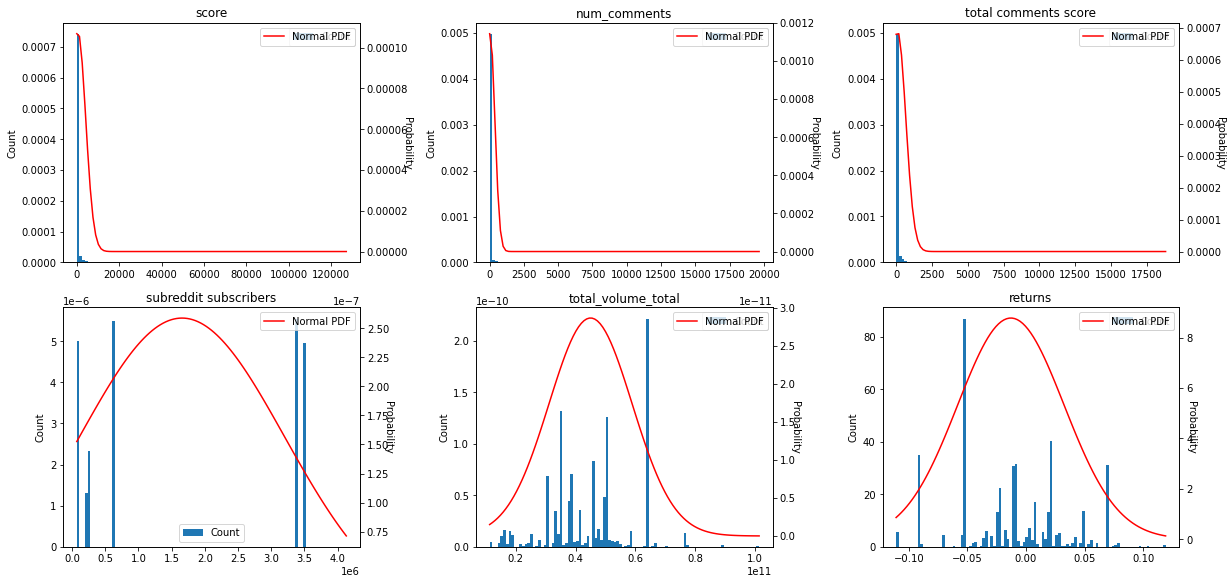

In [79]:
fig, axs = plt.subplots(2,3,figsize=(17,8), constrained_layout=True)
for x in range(2):
    for y in range(3):
        n, bins, patches = axs[x,y].hist(numeric_day_data.iloc[:,y + x*3],bins=100,density=True ,label = 'Count')
        mu,sigma = ss.norm.fit(numeric_day_data.iloc[:,y + x*3])
        prob = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        
        ax2=axs[x,y].twinx()
        ax2.plot(bins, prob, color='red',label = 'Normal PDF')
        ax2.set_ylabel("Probability",fontsize=10,rotation=-90,)
        ax2.legend()
        
        axs[x,y].legend()
        axs[x,y].set_title(numeric_day_data.columns[y + x*3],fontsize=12)
        axs[x,y].set_ylabel('Count',fontsize=10)

<AxesSubplot:>

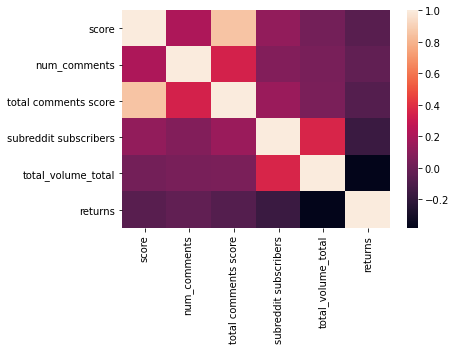

In [80]:
corr = numeric_day_data.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

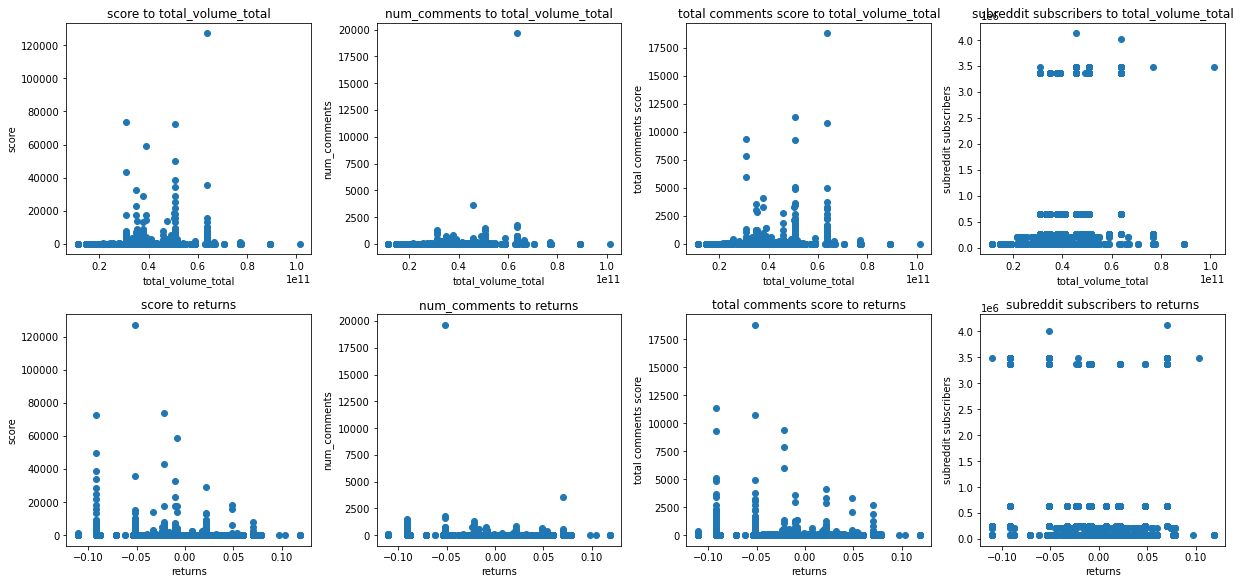

In [81]:
fig, axs = plt.subplots(2,4,figsize=(17,8), constrained_layout=True)
for x in range(2):
    for y in range(4):
        axs[x,y].scatter(y = numeric_day_data.iloc[:,y], x = numeric_day_data.iloc[:,-2:].iloc[:,x])
        axs[x,y].set_title('{} to {}'.format(numeric_day_data.columns[y],numeric_day_data.iloc[:,-2:].columns[x]),fontsize=12)
        axs[x,y].set_xlabel(numeric_day_data.iloc[:,-2:].columns[x],fontsize=10)
        axs[x,y].set_ylabel(numeric_day_data.columns[y],fontsize=10)

### hourly prices

In [95]:
data = pd.read_csv('BTC hour.csv',index_col=0)[['time','close','total_volume_total']]
data['time'] = [datetime.datetime.fromtimestamp(x).replace(minute=0, second=0) for x in data['time']]
data['returns'] = data['close'].pct_change()
data['time'] = data['time'].astype('object')  


reddit_hour = reddit.copy()
reddit_hour['time'] = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").replace(minute=0, second=0) for x in reddit_hour['time']]
reddit_hour['time'] = reddit_hour['time'].astype('object')  

new_df = []
for uniq_time in np.unique(reddit_hour['time']):
    current_time = reddit_day[reddit_day['time']==uniq_time]
    new_df += [[' '.join(current_time['author'].dropna()),sum(current_time['score'].dropna()),' '.join(np.unique(current_time['subreddit'].dropna())),\
    sum(np.unique(current_time['num_comments'].dropna())),' '.join(current_time['body'].dropna()),uniq_time,\
    sum(np.unique(current_time['total comments score'].dropna())),sum(np.unique(current_time['subreddit subscribers'].dropna()))]]
reddit_hour = pd.DataFrame(new_df,columns=['author','score','subreddit','num_comments','body','time','total comments score','subreddit subscribers'])
print(reddit_hour.shape)
reddit_hour.head()

reddit_hour['time'] = reddit_hour['time'].astype('object')  
reddit_hour = pd.merge(reddit_hour, data, on="time").dropna(subset=['returns'])
numeric_hour_data = reddit_hour[['score','num_comments','total comments score','subreddit subscribers','total_volume_total','returns']]

(952, 8)


In [88]:
numeric_hour_data.describe()

,score,num_comments,total comments score,subreddit subscribers,total_volume_total,returns
count,9.52e+02,9.52e+02,9.52e+02,9.52e+02,9.52e+02,9.52e+02
mean,4.3e+04,2.22e+03,7.02e+03,1.8e+06,1.73e+09,-0.000187
std,1.05e+05,6.42e+03,1.88e+04,2.89e+06,9.89e+08,0.00806
min,0.0,0.0,0.0,0.0,3.58e+08,-0.0477
25%,2.03e+02,46.0,44.0,2.81e+05,1.14e+09,-0.00379
50%,4.31e+02,1.09e+02,1.64e+02,2.81e+05,1.58e+09,0.000107
75%,1.34e+04,1.39e+03,1.65e+03,4.03e+06,2.05e+09,0.00391
max,4.63e+05,3.75e+04,9.03e+04,1.19e+07,1.36e+10,0.0343


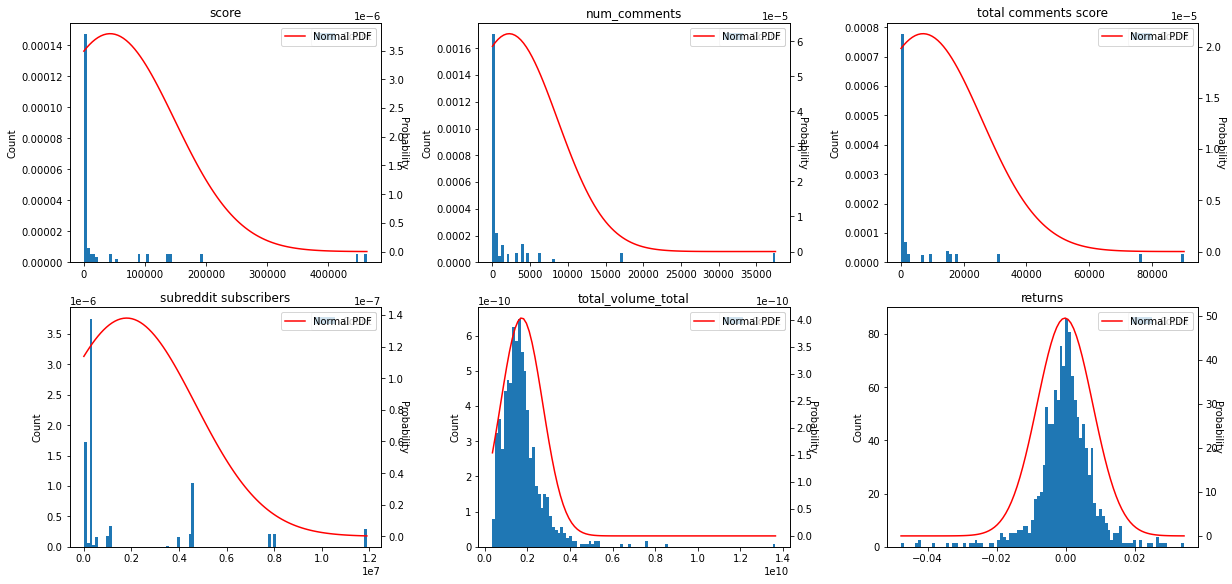

In [89]:
fig, axs = plt.subplots(2,3,figsize=(17,8), constrained_layout=True)
for x in range(2):
    for y in range(3):
        n, bins, patches = axs[x,y].hist(numeric_hour_data.iloc[:,y + x*3],bins=100,density=True ,label = 'Count')
        mu,sigma = ss.norm.fit(numeric_hour_data.iloc[:,y + x*3])
        prob = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        
        ax2=axs[x,y].twinx()
        ax2.plot(bins, prob, color='red',label = 'Normal PDF')
        ax2.set_ylabel("Probability",fontsize=10,rotation=-90,)
        ax2.legend()
        
        axs[x,y].legend()
        axs[x,y].set_title(numeric_hour_data.columns[y + x*3],fontsize=12)
        axs[x,y].set_ylabel('Count',fontsize=10)

<AxesSubplot:>

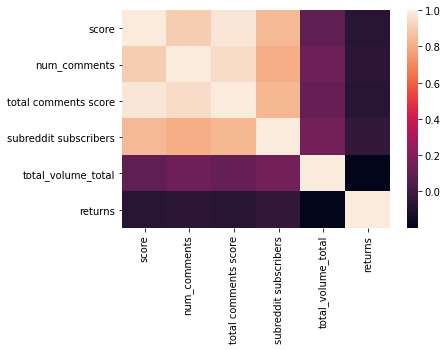

In [90]:
corr = numeric_hour_data.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

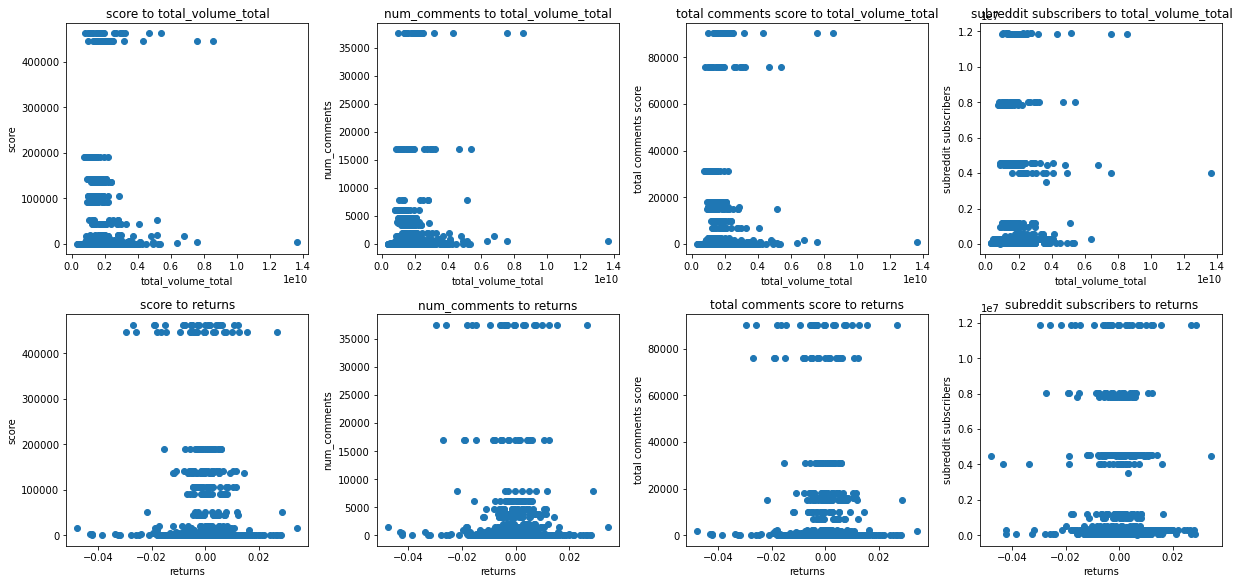

In [91]:
fig, axs = plt.subplots(2,4,figsize=(17,8), constrained_layout=True)
for x in range(2):
    for y in range(4):
        axs[x,y].scatter(y = numeric_hour_data.iloc[:,y], x = numeric_hour_data.iloc[:,-2:].iloc[:,x])
        axs[x,y].set_title('{} to {}'.format(numeric_hour_data.columns[y],numeric_hour_data.iloc[:,-2:].columns[x]),fontsize=12)
        axs[x,y].set_xlabel(numeric_hour_data.iloc[:,-2:].columns[x],fontsize=10)
        axs[x,y].set_ylabel(numeric_hour_data.columns[y],fontsize=10)

### minutely prices

In [96]:
data = pd.read_csv('BTC minute.csv',index_col=0).reset_index(drop=True)
data = data[['date','close','Volume USD']]
data = data.rename(columns = {'date':'time', 'Volume USD':'total_volume_total'})
data['returns'] = data['close'].pct_change()
data['time'] = [datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S") for x in data['time']]
data['time'] = data['time'].astype('object')  



reddit_minute = reddit.copy()
reddit_minute['time'] = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").replace(second=0) for x in reddit_minute['time']]
reddit_minute['time'] = reddit_minute['time'].astype('object')  

new_df = []
for uniq_time in np.unique(reddit_minute['time']):
    current_time = reddit_day[reddit_day['time']==uniq_time]
    new_df += [[' '.join(current_time['author'].dropna()),sum(current_time['score'].dropna()),' '.join(np.unique(current_time['subreddit'].dropna())),\
    sum(np.unique(current_time['num_comments'].dropna())),' '.join(current_time['body'].dropna()),uniq_time,\
    sum(np.unique(current_time['total comments score'].dropna())),sum(np.unique(current_time['subreddit subscribers'].dropna()))]]
reddit_minute = pd.DataFrame(new_df,columns=['author','score','subreddit','num_comments','body','time','total comments score','subreddit subscribers'])
print(reddit_minute.shape)
reddit_minute.head()

reddit_minute['time'] = reddit_minute['time'].astype('object')  
reddit_minute = pd.merge(reddit_minute, data, on="time").dropna(subset=['returns'])
numeric_minute_data = reddit_minute[['score','num_comments','total comments score','subreddit subscribers','total_volume_total','returns']]

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(3220, 8)


In [97]:
numeric_minute_data.describe()

,score,num_comments,total comments score,subreddit subscribers,total_volume_total,returns
count,3.22e+03,3.22e+03,3.22e+03,3.22e+03,3.22e+03,3.22e+03
mean,1.56e+05,9.65e+03,2.77e+04,5.22e+06,9.46e+04,-1.64e-05
std,1.8e+05,1.35e+04,3.48e+04,4.42e+06,2.29e+05,0.00136
min,0.0,0.0,0.0,0.0,0.0,-0.0198
25%,8.14e+02,1.65e+02,3.4e+02,2.81e+05,4.4e+03,-0.000545
50%,9.17e+04,3.76e+03,1.5e+04,4.55e+06,2.23e+04,0.0
75%,4.46e+05,1.7e+04,7.59e+04,8.04e+06,8.41e+04,0.000545
max,4.63e+05,3.75e+04,9.03e+04,1.19e+07,4.07e+06,0.0108


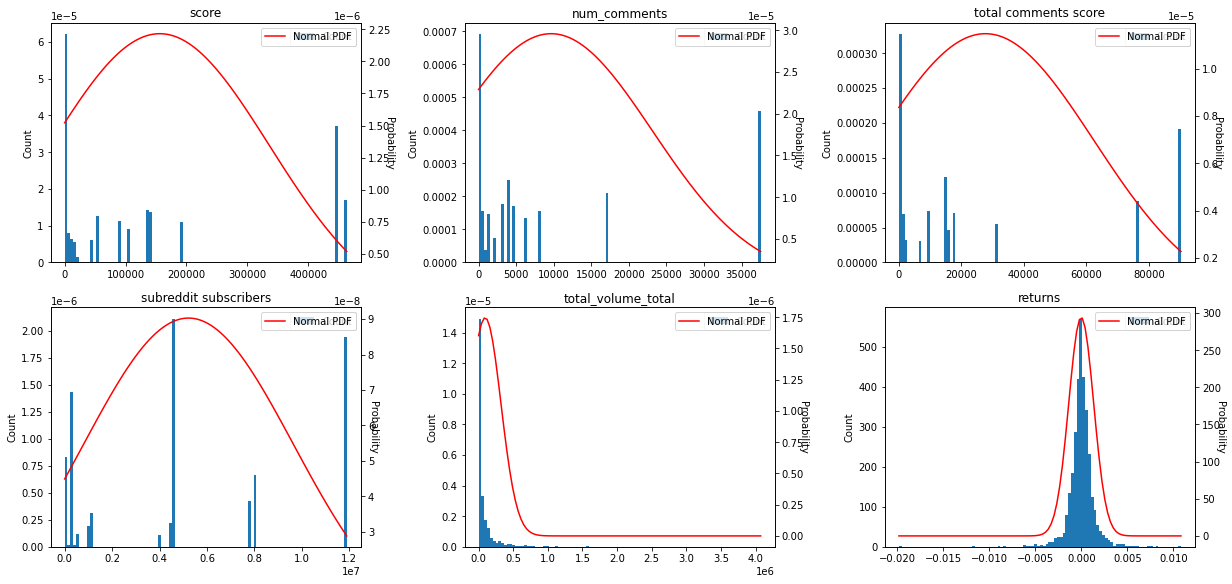

In [98]:
fig, axs = plt.subplots(2,3,figsize=(17,8), constrained_layout=True)
for x in range(2):
    for y in range(3):
        n, bins, patches = axs[x,y].hist(numeric_minute_data.iloc[:,y + x*3],bins=100,density=True ,label = 'Count')
        mu,sigma = ss.norm.fit(numeric_minute_data.iloc[:,y + x*3])
        prob = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        
        ax2=axs[x,y].twinx()
        ax2.plot(bins, prob, color='red',label = 'Normal PDF')
        ax2.set_ylabel("Probability",fontsize=10,rotation=-90,)
        ax2.legend()
        
        axs[x,y].legend()
        axs[x,y].set_title(numeric_minute_data.columns[y + x*3],fontsize=12)
        axs[x,y].set_ylabel('Count',fontsize=10)

<AxesSubplot:>

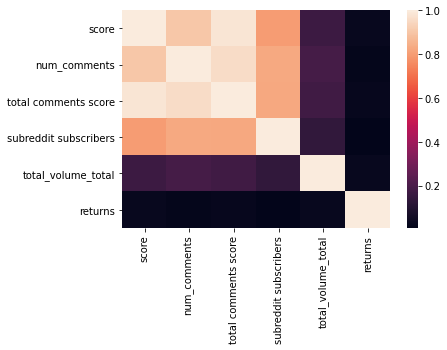

In [99]:
corr = numeric_minute_data.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

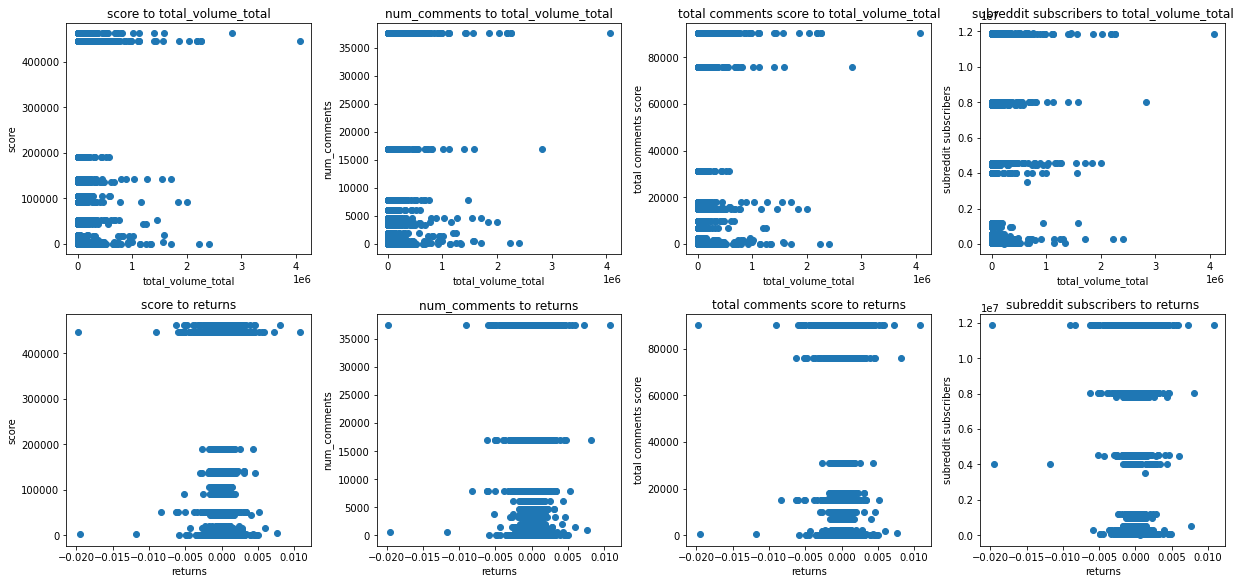

In [100]:
fig, axs = plt.subplots(2,4,figsize=(17,8), constrained_layout=True)
for x in range(2):
    for y in range(4):
        axs[x,y].scatter(y = numeric_minute_data.iloc[:,y], x = numeric_minute_data.iloc[:,-2:].iloc[:,x])
        axs[x,y].set_title('{} to {}'.format(numeric_minute_data.columns[y],numeric_minute_data.iloc[:,-2:].columns[x]),fontsize=12)
        axs[x,y].set_xlabel(numeric_minute_data.iloc[:,-2:].columns[x],fontsize=10)
        axs[x,y].set_ylabel(numeric_minute_data.columns[y],fontsize=10)

## Twitter

In [26]:
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

def getPolarity(review):
        return TextBlob(review).sentiment.polarity

def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

def sentiwordnetanalysispos(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = lem.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1

        if not tokens_count:
            return 0
        if sentiment>0:
            return "Positive"
        if sentiment==0:
            return "Neutral"
        else:
            return "Negative"
        
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = lem.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        return sentiment
        
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [27]:
twitter = pd.read_csv('Twitter.csv',index_col=0)
twitter = twitter.head(10000)
content = twitter['content'].tolist()
twitter['date'] = [datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S%z").replace(second=0,tzinfo=None) for x in twitter['date']]
twitter = twitter.rename(columns={'date':'time'})
twitter['time'] = twitter['time'].astype('object') 

twitter.head()

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,time,id,content,username,subreddit
0,2021-09-23 16:02:00,1.44e+18,@hardmoneymag Peter Schiff… once you hold gold...,BankerWeimar,Bitcoin
1,2021-09-23 16:02:00,1.44e+18,"They meant P$100,000 (2k USD) . \n#Bitcoin #Bi...",bong_gonggong,Bitcoin
2,2021-09-23 16:02:00,1.44e+18,#Bitcoin $BTC https://t.co/rei3HRtFc0 https://...,DollaBillCrypto,Bitcoin
3,2021-09-23 16:02:00,1.44e+18,Bitcoin - $43930.0 (€37438.0)\nEthereum - ...,CryptoBotPrice,Bitcoin
4,2021-09-23 16:02:00,1.44e+18,Satoshi Spekülasyonu: 2012’den Beri Uykuda Ola...,turkcekripto,Bitcoin


In [28]:
data = pd.read_csv('BTC minute.csv',index_col=0).reset_index(drop=True)
data = data[['date','close','Volume USD']]
data = data.rename(columns = {'date':'time', 'Volume USD':'total_volume_total'})
data['returns'] = data['close'].pct_change()
data['time'] = [datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S") for x in data['time']]
data['time'] = data['time'].astype('object')  

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
twitter = pd.merge(twitter, data, on="time").dropna(subset=['returns'])
twitter = twitter[['time','content','total_volume_total','returns']]

### Преобразование текста

In [30]:
new_content = []
new_token_slice = []
for text_slice in content:
    new_text_slice = re.sub('[^A-Za-z]+', ' ',' '.join([y.replace('\n',' ').lower() for y in text_slice.split(' ') if '@' not in y and 'http' not in y and '#' not in y]))
    filtered_sent=[]
    for w in new_text_slice.split(' '):
        if w not in stop_words:
            filtered_sent.append(w)
    new_text_slice = ' '.join([lem.lemmatize(x,"v") for x in filtered_sent])
    token_slice = word_tokenize(new_text_slice)
    new_token_slice += [token_slice]
    new_content += [new_text_slice]

In [34]:
dic=defaultdict(int)
for word in sum(new_token_slice,[]):
        dic[word]+=1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

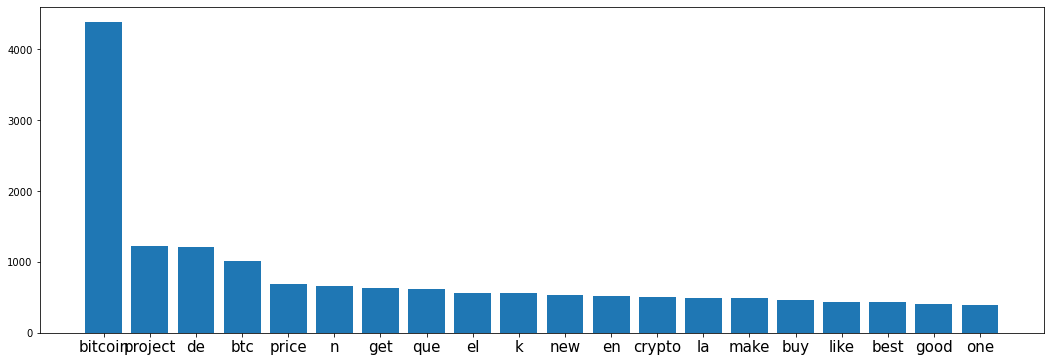

In [35]:
plt.figure(figsize=(18, 6))
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 
x,y=zip(*top)
plt.bar(x,y)
plt.xticks(fontsize=15)[0]

In [36]:
twitter['content'] = new_content
twitter = twitter[[len(x.split())>1 for x in twitter['content']]].reset_index(drop=True)

### Определение тона

In [37]:
twitter['Subjectivity'] = twitter['content'].apply(getSubjectivity) 
twitter['Polarity'] = twitter['content'].apply(getPolarity) 
twitter['Analysis'] = twitter['Polarity'].apply(analysis)
twitter.head()

,time,content,total_volume_total,returns,Subjectivity,Polarity,Analysis
0,2021-09-23 16:02:00,peter schiff hold gold silver walk away fiat l...,6.23e+04,0.000466,0.0,0.0,Neutral
1,2021-09-23 16:02:00,mean p k usd,6.23e+04,0.000466,0.688,-0.312,Negative
2,2021-09-23 16:02:00,bitcoin ethereum chainlink solana litecoin,6.23e+04,0.000466,0.0,0.0,Neutral
3,2021-09-23 16:02:00,satoshi spek lasyonu den beri uykuda olan bitc...,6.23e+04,0.000466,0.0,0.0,Neutral
4,2021-09-23 16:02:00,know check bme,6.23e+04,0.000466,0.0,0.0,Neutral


In [38]:
analyzer = SentimentIntensityAnalyzer()
twitter['Vader Sentiment'] = twitter['content'].apply(vadersentimentanalysis)
twitter['Vader Analysis'] = twitter['Vader Sentiment'].apply(vader_analysis)
twitter.head()

,time,content,total_volume_total,returns,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,2021-09-23 16:02:00,peter schiff hold gold silver walk away fiat l...,6.23e+04,0.000466,0.0,0.0,Neutral,0.557,Positive
1,2021-09-23 16:02:00,mean p k usd,6.23e+04,0.000466,0.688,-0.312,Negative,0.0,Neutral
2,2021-09-23 16:02:00,bitcoin ethereum chainlink solana litecoin,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral
3,2021-09-23 16:02:00,satoshi spek lasyonu den beri uykuda olan bitc...,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral
4,2021-09-23 16:02:00,know check bme,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral


In [39]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
twitter['POS tagged'] = twitter['content'].apply(token_stop_pos)
twitter.head()

,time,content,total_volume_total,returns,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,POS tagged
0,2021-09-23 16:02:00,peter schiff hold gold silver walk away fiat l...,6.23e+04,0.000466,0.0,0.0,Neutral,0.557,Positive,"[(peter, n), (schiff, n), (hold, v), (gold, n)..."
1,2021-09-23 16:02:00,mean p k usd,6.23e+04,0.000466,0.688,-0.312,Negative,0.0,Neutral,"[(mean, a), (p, n), (k, n), (usd, n)]"
2,2021-09-23 16:02:00,bitcoin ethereum chainlink solana litecoin,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral,"[(bitcoin, n), (ethereum, n), (chainlink, n), ..."
3,2021-09-23 16:02:00,satoshi spek lasyonu den beri uykuda olan bitc...,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral,"[(satoshi, n), (spek, n), (lasyonu, n), (den, ..."
4,2021-09-23 16:02:00,know check bme,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral,"[(know, v), (check, n), (bme, n)]"


In [40]:
twitter['SWN analysis'] = twitter['POS tagged'].apply(sentiwordnetanalysispos)
twitter['SWN Sentiment'] = twitter['POS tagged'].apply(sentiwordnetanalysis)
twitter

,time,content,total_volume_total,returns,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,POS tagged,SWN analysis,SWN Sentiment
0,2021-09-23 16:02:00,peter schiff hold gold silver walk away fiat l...,6.23e+04,0.000466,0.0,0.0,Neutral,0.557,Positive,"[(peter, n), (schiff, n), (hold, v), (gold, n)...",Neutral,0.0
1,2021-09-23 16:02:00,mean p k usd,6.23e+04,0.000466,0.688,-0.312,Negative,0.0,Neutral,"[(mean, a), (p, n), (k, n), (usd, n)]",Neutral,0.0
2,2021-09-23 16:02:00,bitcoin ethereum chainlink solana litecoin,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral,"[(bitcoin, n), (ethereum, n), (chainlink, n), ...",None,NaN
3,2021-09-23 16:02:00,satoshi spek lasyonu den beri uykuda olan bitc...,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral,"[(satoshi, n), (spek, n), (lasyonu, n), (den, ...",Positive,0.125
4,2021-09-23 16:02:00,know check bme,6.23e+04,0.000466,0.0,0.0,Neutral,0.0,Neutral,"[(know, v), (check, n), (bme, n)]",Neutral,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8594,2021-09-23 13:20:00,look super bearish could great buy,1.12e+03,-0.000208,0.708,0.567,Positive,0.84,Positive,"[(look, n), (super, a), (bearish, n), (could, ...",Neutral,0.0
8595,2021-09-23 13:20:00,give choice would rather buy today,1.12e+03,-0.000208,0.0,0.0,Neutral,0.0,Neutral,"[(give, a), (choice, n), (would, None), (rathe...",Neutral,0.0
8596,2021-09-23 13:20:00,bitcoin gibi oldu birisi zengin olunca geri er,1.12e+03,-0.000208,0.0,0.0,Neutral,0.0,Neutral,"[(bitcoin, n), (gibi, n), (oldu, n), (birisi, ...",Neutral,0.0
8597,2021-09-23 13:20:00,bitcoin ethereum destekleniyor sol kseliyor,1.12e+03,-0.000208,0.0,0.0,Neutral,0.0,Neutral,"[(bitcoin, n), (ethereum, n), (destekleniyor, ...",Neutral,0.0


In [41]:
tb_counts = twitter['Analysis'].value_counts()
vader_counts = twitter['Vader Analysis'].value_counts()
swn_counts = twitter['SWN analysis'].value_counts()

([<matplotlib.patches.Wedge at 0x13886f3e4f0>,
 [Text(-0.7086032836906752, 0.8413568721670922, 'Neutral'),
  Text(0.4532091287845038, -1.002298102156435, 'Positive'),
  Text(1.2991640163785332, -0.3669780082609836, 'Negative')],
 [Text(-0.38651088201309547, 0.45892193027295936, '72.3%'),
  Text(0.24720497933700206, -0.5467080557216917, '19.0%'),
  Text(0.8179921584605578, -0.2310602274235822, '8.8%')])

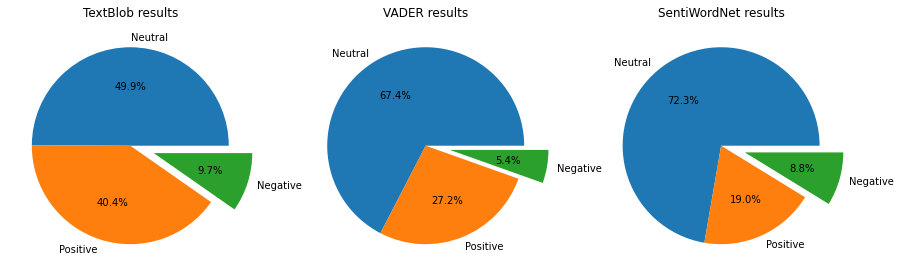

In [42]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob results")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results")
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [43]:
for name in ['Analysis','Vader Analysis','SWN analysis']:
    twitter_short = twitter.loc[twitter[twitter['Vader Analysis']=='Positive'].index.tolist() + twitter[twitter['Vader Analysis']=='Negative'].index.tolist()]
    documents = [(twitter_short['content'].iloc[x].split(' '), twitter_short['Vader Analysis'].iloc[x]) for x in range(twitter_short.shape[0])]
    random.shuffle(documents)
    all_words = nltk.FreqDist(sum([x.split(' ') for x in twitter_short['content']],[]))
    word_features = list(all_words)[:2000]
    featuresets = [(document_features(d), c) for (d,c) in documents]
    train_set, test_set = featuresets[150:], featuresets[:150]
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    
    print(name,nltk.classify.accuracy(classifier, test_set))
    
    classifier.show_most_informative_features(10)

Analysis 0.94
Most Informative Features
         contains(desde) = True           Negati : Positi =     76.0 : 1.0
         contains(final) = True           Negati : Positi =     76.0 : 1.0
        contains(perfil) = True           Negati : Positi =     72.8 : 1.0
           contains(ver) = True           Negati : Positi =     72.8 : 1.0
          contains(shit) = True           Negati : Positi =     66.3 : 1.0
           contains(con) = True           Negati : Positi =     57.2 : 1.0
          contains(fail) = True           Negati : Positi =     57.2 : 1.0
          contains(scam) = True           Negati : Positi =     54.7 : 1.0
       contains(project) = True           Positi : Negati =     50.3 : 1.0
         contains(nadie) = True           Negati : Positi =     45.6 : 1.0
Vader Analysis 0.88
Most Informative Features
         contains(final) = True           Negati : Positi =     82.9 : 1.0
        contains(perfil) = True           Negati : Positi =     79.6 : 1.0
           con

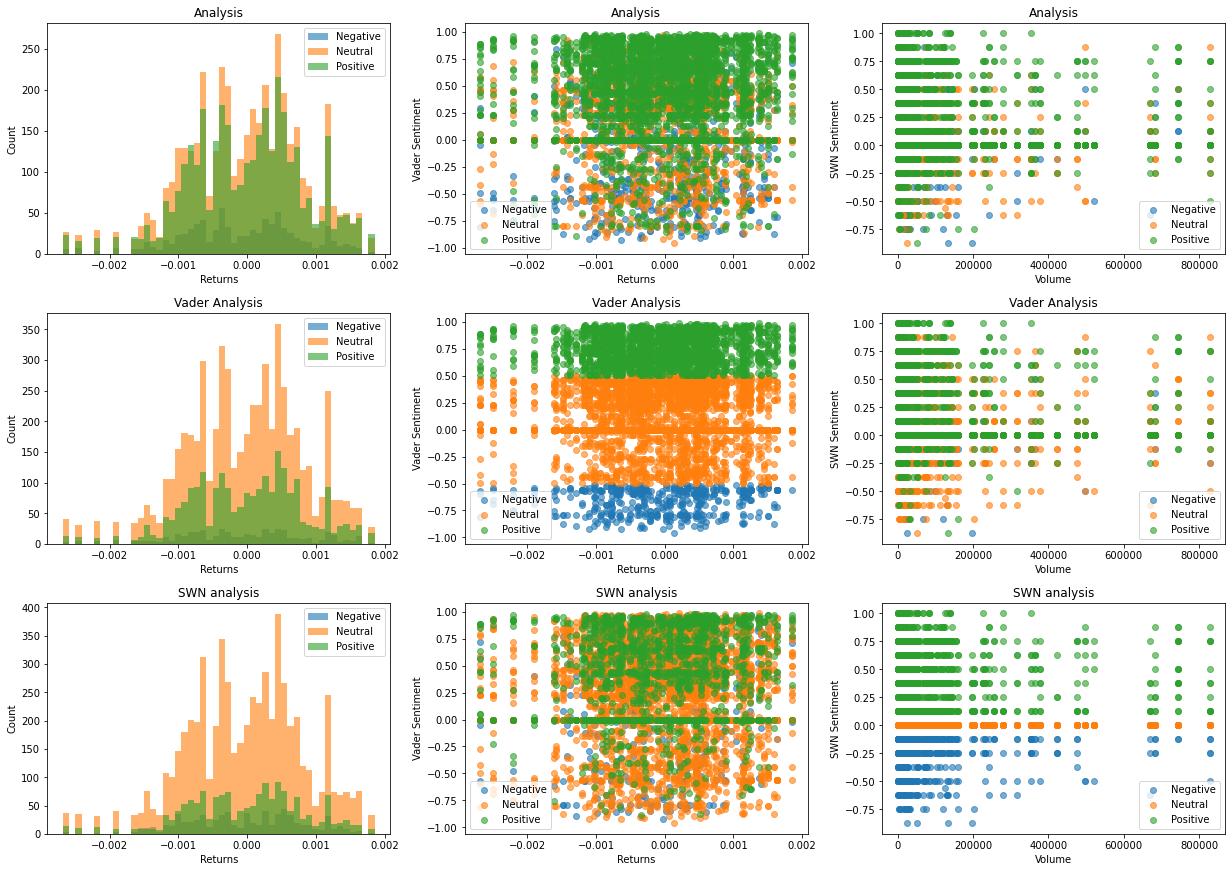

In [44]:
fig, axs = plt.subplots(3,3,figsize=(17,12), constrained_layout=True)

sentement_type = ['Polarity','Vader Sentiment','SWN Sentiment']
method = ['Analysis','Vader Analysis','SWN analysis']
for x in range(3):
    for y in range(3):
        if y == 0:
            for v in np.unique(twitter[method[x]].dropna()):
                axs[x,y].hist(twitter[twitter[method[x]]==v]['returns'], alpha=0.6,bins=50,label = v)
            axs[x,y].legend()
            axs[x,y].set_xlabel('Returns',fontsize=10)
            axs[x,y].set_ylabel('Count',fontsize=10)
            axs[x,y].set_title(method[x])
        elif y == 1:
            for v in np.unique(twitter[method[x]].dropna()):
                axs[x,y].scatter(y = twitter[twitter[method[x]]==v][sentement_type[y]], x = twitter[twitter[method[x]]==v]['returns'], alpha=0.6,label = v)
            axs[x,y].legend()
            axs[x,y].set_xlabel('Returns',fontsize=10)
            axs[x,y].set_ylabel(sentement_type[y],fontsize=10)
            axs[x,y].set_title(method[x])
        else:
            for v in np.unique(twitter[method[x]].dropna()):
                axs[x,y].scatter(y = twitter[twitter[method[x]]==v][sentement_type[y]], x = twitter[twitter[method[x]]==v]['total_volume_total'], alpha=0.6,label = v)
            axs[x,y].legend()
            axs[x,y].set_xlabel('Volume',fontsize=10)
            axs[x,y].set_ylabel(sentement_type[y],fontsize=10)
            axs[x,y].set_title(method[x])

<AxesSubplot:>

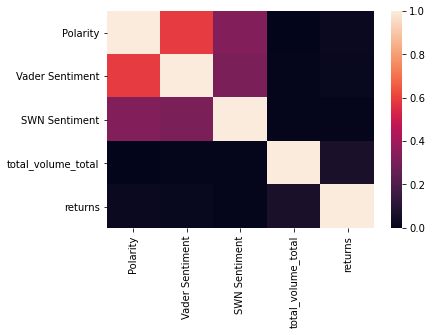

In [46]:
corr = twitter[['Polarity','Vader Sentiment','SWN Sentiment']+['total_volume_total','returns']].corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)